In [1]:
pip install pandas numpy matplotlib requests census us

In [2]:
# Import Libraries
import numpy as np
import pandas as pd
import requests
import io
import concurrent.futures
import time
from tqdm.notebook import tqdm  # Better progress bars in Jupyter
import matplotlib.pyplot as plt  # For visualization if needed

In [3]:
# Import your credentials directly
from config import credentials

# BLS Industry over and under representation analysis

In [4]:
# Get BLS API key
api_key = credentials['BLS_API_KEY']


In [5]:
# ---- Configuration ----
# TOGGLE THIS FLAG to switch between test counties and all counties
# Set to False for test counties, True for all counties
USE_ALL_COUNTIES = True

# Test counties for initial analysis
test_counties = {
    "36061": "New York County, NY",
    "06037": "Los Angeles County, CA",
    "17031": "Cook County, IL",
    "48201": "Harris County, TX",
    "06075": "San Francisco County, CA"
}

# Define output prefix for filenames
output_prefix = "test_" if not USE_ALL_COUNTIES else ""

# Year to analyze
analysis_year = 2023

# Private sector ownership code
PRIVATE_OWNERSHIP_CODE = 5

# Maximum concurrent workers
MAX_WORKERS = 5

In [6]:
# State FIPS to abbreviation mapping
state_lookup = {
    '01': 'AL', '02': 'AK', '04': 'AZ', '05': 'AR', '06': 'CA', '08': 'CO', '09': 'CT', 
    '10': 'DE', '11': 'DC', '12': 'FL', '13': 'GA', '15': 'HI', '16': 'ID', '17': 'IL', 
    '18': 'IN', '19': 'IA', '20': 'KS', '21': 'KY', '22': 'LA', '23': 'ME', '24': 'MD', 
    '25': 'MA', '26': 'MI', '27': 'MN', '28': 'MS', '29': 'MO', '30': 'MT', '31': 'NE', 
    '32': 'NV', '33': 'NH', '34': 'NJ', '35': 'NM', '36': 'NY', '37': 'NC', '38': 'ND', 
    '39': 'OH', '40': 'OK', '41': 'OR', '42': 'PA', '44': 'RI', '45': 'SC', '46': 'SD', 
    '47': 'TN', '48': 'TX', '49': 'UT', '50': 'VT', '51': 'VA', '53': 'WA', '54': 'WV', 
    '55': 'WI', '56': 'WY'
}

In [7]:
# ---- Functions for Reference Data ----
def get_industry_titles():
    """Download and parse the BLS industry titles reference file"""
    try:
        # Download the industry titles CSV
        url = "https://data.bls.gov/cew/doc/titles/industry/industry_titles.csv"
        print(f"Downloading industry titles from: {url}")
        response = requests.get(url)
        
        if response.status_code == 200:
            # Parse the CSV file
            industry_df = pd.read_csv(io.StringIO(response.text))
            # Create a dictionary mapping codes to titles
            industry_dict = industry_df.set_index('industry_code')['industry_title'].to_dict()
            print(f"Downloaded {len(industry_dict)} industry titles")
            return industry_dict
        else:
            print(f"Failed to download industry titles: Status code {response.status_code}")
            # Fallback to basic NAICS 2-digit sectors
            return create_basic_naics_dict()
    except Exception as e:
        print(f"Error downloading industry titles: {str(e)}")
        # Fallback to basic NAICS 2-digit sectors
        return create_basic_naics_dict()

def get_area_titles():
    """Download and parse the BLS area titles reference file"""
    try:
        # Download the area titles CSV
        url = "https://data.bls.gov/cew/doc/titles/area/area_titles.csv"
        print(f"Downloading area titles from: {url}")
        response = requests.get(url)
        
        if response.status_code == 200:
            # Parse the CSV file
            area_df = pd.read_csv(io.StringIO(response.text))
            # Create a dictionary mapping codes to titles
            area_dict = area_df.set_index('area_fips')['area_title'].to_dict()
            print(f"Downloaded {len(area_dict)} area titles")
            return area_dict
        else:
            print(f"Failed to download area titles: Status code {response.status_code}")
            return {}
    except Exception as e:
        print(f"Error downloading area titles: {str(e)}")
        return {}

def create_basic_naics_dict():
    """Create a basic NAICS sector dictionary as fallback"""
    print("Creating basic NAICS sector dictionary as fallback...")
    naics_2digit = {
        '11': 'Agriculture, Forestry, Fishing and Hunting',
        '21': 'Mining, Quarrying, and Oil and Gas Extraction',
        '22': 'Utilities',
        '23': 'Construction',
        '31': 'Manufacturing',
        '32': 'Manufacturing',
        '33': 'Manufacturing',
        '42': 'Wholesale Trade',
        '44': 'Retail Trade',
        '45': 'Retail Trade',
        '48': 'Transportation and Warehousing',
        '49': 'Transportation and Warehousing',
        '51': 'Information',
        '52': 'Finance and Insurance',
        '53': 'Real Estate and Rental and Leasing',
        '54': 'Professional, Scientific, and Technical Services',
        '55': 'Management of Companies and Enterprises',
        '56': 'Administrative and Support and Waste Management and Remediation Services',
        '61': 'Educational Services',
        '62': 'Health Care and Social Assistance',
        '71': 'Arts, Entertainment, and Recreation',
        '72': 'Accommodation and Food Services',
        '81': 'Other Services (except Public Administration)',
        '92': 'Public Administration',
        '10': 'Total, All Industries'
    }
    return naics_2digit

In [8]:
# ---- County FIPS Retrieval Function ----
def get_all_county_fips():
    """Get all county FIPS codes from Census"""
    print("Fetching all county FIPS codes...")
    
    try:
        # 1) read both FIPS fields as strings
        census_url = "https://www2.census.gov/geo/docs/reference/codes/files/national_county.txt"
        counties_df = pd.read_csv(
            census_url,
            header=None,
            sep=',',
            names=['state_postal','state_fips','county_fips','county_name','class_code'],
            dtype={'state_fips': str, 'county_fips': str}
        )
        
        # 2) zero‑pad each component to the proper width
        counties_df['state_fips'] = counties_df['state_fips'].str.zfill(2)   # "1"→"01"
        counties_df['county_fips'] = counties_df['county_fips'].str.zfill(3)  # "1"→"001"
        
        # 3) now truly concatenate to get 5‑digit GEOID
        counties_df['area_fips'] = counties_df['state_fips'] + counties_df['county_fips']
        
        # 4) build name lookup
        county_dict = counties_df.set_index('area_fips')['county_name'].to_dict()
        
        # 5) attach state abbreviation
        county_fips_dict = {}
        for fips_str, name in county_dict.items():
            state_abbr = state_lookup.get(fips_str[:2], '??')
            county_fips_dict[fips_str] = f"{name}, {state_abbr}"
        
        print(f"Retrieved {len(county_fips_dict)} county FIPS codes")
        
        # ——— show a few examples ———
        print("\nSample county FIPS → name:")
        for fips, nm in list(county_fips_dict.items())[:10]:
            print(f"  {fips}: {nm}")
        
        return county_fips_dict
    
    except Exception as e:
        print(f"Error retrieving county FIPS codes: {str(e)}")
        return {}

In [9]:
# ---- Data Fetching Functions with Concurrency ----
def fetch_qcew_data(year, quarter, area_code, area_name=None, retries=3, delay=1):
    """
    Fetch QCEW data for a specific area (county or national)
    """
    # Build URL for this specific area
    qcew_url = f"https://data.bls.gov/cew/data/api/{year}/{quarter}/area/{area_code}.csv"
    
    for attempt in range(retries):
        try:
            response = requests.get(qcew_url, timeout=10)  # Adding timeout
            if response.status_code == 200:
                df = pd.read_csv(io.StringIO(response.text))
                
                # Add metadata columns
                if area_name:
                    df['area_title'] = area_name
                df['area_fips'] = area_code
                df['industry_code'] = df['industry_code'].astype(str)
                df['ownership_code'] = df['own_code']
                df['quarter'] = quarter
                df['year'] = year
                
                # Filter for ownership code 5 (private sector)
                df = df[df['ownership_code'] == PRIVATE_OWNERSHIP_CODE]
                
                # OPTION 1: Filter for only 2-digit NAICS codes and total (code 10)
                # This option is faster and more efficient for analysis focused on 2-digit codes
                # Uncomment this block to use only 2-digit NAICS codes:
                
                df = df[
                    # 2-digit NAICS codes
                    ((df['industry_code'].str.len() == 2) & 
                     (df['industry_code'].str.match(r'^\d{2}$'))) |
                    # Total, all industries code
                    (df['industry_code'] == '10')
                ]
                
                # OPTION 2: Use all NAICS codes (Comment out Option 1 and uncomment this if needed)
                # This option retrieves all industry levels, but requires more processing time
                # 
                # # No additional filtering for NAICS codes
                # pass
                
                # If no data remains after filtering, return empty dataframe
                if len(df) == 0:
                    print(f"  No applicable data for {area_name}")
                    return pd.DataFrame(columns=df.columns)
                
                return df
            
            # If request failed, retry after delay
            if attempt < retries - 1:
                time.sleep(delay)
                continue
                
            return None  # All retries failed
            
        except Exception as e:
            if attempt < retries - 1:
                time.sleep(delay)
                continue
            
            print(f"  Error fetching data for {area_name}: {e}")
            return None
    
    return None

In [10]:
def fetch_data_concurrent(year, quarter, areas_dict, industry_titles_dict, max_workers=5):
    """
    Fetch data for all areas in parallel for a specific quarter
    """
    print(f"Fetching Q{quarter} {year} data concurrently...")
    
    # Create a list of tasks
    tasks = [(area_code, area_name) for area_code, area_name in areas_dict.items()]
    results = []
    
    # Use ThreadPoolExecutor for concurrent API calls
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        futures = {
            executor.submit(fetch_qcew_data, year, quarter, area_code, area_name): 
            (area_code, area_name) for area_code, area_name in tasks
        }
        
        # Process completed tasks with a progress bar
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), 
                           desc=f"Q{quarter} Progress"):
            area_code, area_name = futures[future]
            try:
                df = future.result()
                if df is not None and len(df) > 0:
                    # Add industry titles
                    df['industry_title'] = df['industry_code'].map(industry_titles_dict)
                    if df['industry_title'].isna().any():
                        missing = df['industry_title'].isna().sum()
                        print(f"  Note: {missing} industry codes unmapped for {area_name}")
                        df['industry_title'].fillna(df['industry_code'], inplace=True)
                    
                    results.append(df)
                    print(f"  Retrieved {len(df)} rows for {area_name}")
                elif df is not None and len(df) == 0:
                    print(f"  No private sector data for {area_name}")
                else:
                    print(f"  Failed to fetch data for {area_name}")
            except Exception as e:
                print(f"  Error processing data for {area_name}: {e}")
    
    # Combine results
    if results:
        quarter_df = pd.concat(results, ignore_index=True)
        print(f"Retrieved Q{quarter} data: {len(quarter_df)} total rows")
        return quarter_df
    else:
        print(f"No data retrieved for Q{quarter}")
        return None

In [11]:
# Get reference data
industry_titles_dict = get_industry_titles()
area_titles_dict = get_area_titles()

# Get county list
if USE_ALL_COUNTIES:
    county_fips_dict = get_all_county_fips()
else:
    county_fips_dict = test_counties
    print(f"Using {len(county_fips_dict)} test counties for analysis")

# Add national level
all_areas = county_fips_dict.copy()
all_areas['US000'] = 'United States'
if 'US000' in area_titles_dict:
    all_areas['US000'] = area_titles_dict['US000']

Downloaded 2678 industry titles
Downloaded 4809 area titles
Fetching all county FIPS codes...
Retrieved 3235 county FIPS codes

Sample county FIPS → name:
  01001: Autauga County, AL
  01003: Baldwin County, AL
  01005: Barbour County, AL
  01007: Bibb County, AL
  01009: Blount County, AL
  01011: Bullock County, AL
  01013: Butler County, AL
  01015: Calhoun County, AL
  01017: Chambers County, AL
  01019: Cherokee County, AL


In [12]:
# Fetch quarterly data concurrently
quarterly_data = []
for quarter in range(1, 5):
    quarter_df = fetch_data_concurrent(
        analysis_year, 
        quarter, 
        all_areas, 
        industry_titles_dict, 
        max_workers=MAX_WORKERS
    )
    if quarter_df is not None:
        quarterly_data.append(quarter_df)

# Combine quarterly data
if quarterly_data:
    all_quarters = pd.concat(quarterly_data, ignore_index=True)
    print(f"Combined quarterly data: {len(all_quarters)} rows")
    
    # Print NAICS industry info
    naics_info = all_quarters[['industry_code','industry_title']].drop_duplicates().sort_values('industry_code')
    print(f"Number of unique NAICS industries: {len(naics_info)}")
    print("NAICS code length distribution:")
    print(all_quarters['industry_code'].apply(len).value_counts())
else:
    print("No quarterly data retrieved. Exiting.")

Fetching Q1 2023 data concurrently...


Q1 Progress:   0%|          | 0/3236 [00:00<?, ?it/s]

  Retrieved 17 rows for Bibb County, AL
  Retrieved 14 rows for Bullock County, AL
  Retrieved 17 rows for Blount County, AL
  Retrieved 15 rows for Butler County, AL
  Retrieved 18 rows for Baldwin County, AL
  Retrieved 15 rows for Chambers County, AL
  Retrieved 17 rows for Autauga County, AL
  Retrieved 16 rows for Choctaw County, AL
  Retrieved 16 rows for Cherokee County, AL
  Retrieved 17 rows for Calhoun County, AL
  Retrieved 17 rows for Chilton County, AL
  Retrieved 15 rows for Clay County, AL
  Retrieved 17 rows for Clarke County, AL
  Retrieved 15 rows for Cleburne County, AL
  Retrieved 16 rows for Coffee County, AL
  Retrieved 17 rows for Barbour County, AL
  Retrieved 17 rows for Colbert County, AL
  Retrieved 17 rows for Covington County, AL
  Retrieved 16 rows for Coosa County, AL
  Retrieved 17 rows for Dale County, AL
  Retrieved 17 rows for Conecuh County, AL
  Retrieved 17 rows for Cullman County, AL
  Retrieved 17 rows for Dallas County, AL
  Retrieved 17 rows fo

Q2 Progress:   0%|          | 0/3236 [00:00<?, ?it/s]

  Retrieved 17 rows for Autauga County, AL
  Retrieved 14 rows for Bullock County, AL
  Retrieved 17 rows for Barbour County, AL
  Retrieved 17 rows for Bibb County, AL
  Retrieved 17 rows for Blount County, AL
  Retrieved 18 rows for Baldwin County, AL
  Retrieved 15 rows for Butler County, AL
  Retrieved 15 rows for Chambers County, AL
  Retrieved 17 rows for Chilton County, AL
  Retrieved 16 rows for Choctaw County, AL
  Retrieved 16 rows for Cherokee County, AL
  Retrieved 15 rows for Cleburne County, AL
  Retrieved 15 rows for Clay County, AL
  Retrieved 17 rows for Calhoun County, AL
  Retrieved 16 rows for Coffee County, AL
  Retrieved 17 rows for Conecuh County, AL
  Retrieved 17 rows for Covington County, AL
  Retrieved 16 rows for Coosa County, AL
  Retrieved 17 rows for Colbert County, AL
  Retrieved 17 rows for Cullman County, AL
  Retrieved 17 rows for Clarke County, AL
  Retrieved 17 rows for DeKalb County, AL
  Retrieved 16 rows for Crenshaw County, AL
  Retrieved 17 row

Q3 Progress:   0%|          | 0/3236 [00:00<?, ?it/s]

  Retrieved 17 rows for Blount County, AL
  Retrieved 14 rows for Bullock County, AL
  Retrieved 17 rows for Bibb County, AL
  Retrieved 17 rows for Barbour County, AL
  Retrieved 17 rows for Autauga County, AL
  Retrieved 15 rows for Butler County, AL
  Retrieved 15 rows for Chambers County, AL
  Retrieved 16 rows for Cherokee County, AL
  Retrieved 16 rows for Choctaw County, AL
  Retrieved 17 rows for Chilton County, AL
  Retrieved 15 rows for Clay County, AL
  Retrieved 17 rows for Calhoun County, AL
  Retrieved 17 rows for Clarke County, AL
  Retrieved 15 rows for Cleburne County, AL
  Retrieved 16 rows for Coffee County, AL
  Retrieved 18 rows for Baldwin County, AL
  Retrieved 17 rows for Conecuh County, AL
  Retrieved 17 rows for Covington County, AL
  Retrieved 17 rows for Dale County, AL
  Retrieved 16 rows for Crenshaw County, AL
  Retrieved 16 rows for Coosa County, AL
  Retrieved 17 rows for Dallas County, AL
  Retrieved 17 rows for Colbert County, AL
  Retrieved 17 rows f

Q4 Progress:   0%|          | 0/3236 [00:00<?, ?it/s]

  Retrieved 17 rows for Autauga County, AL
  Retrieved 14 rows for Bullock County, AL
  Retrieved 18 rows for Baldwin County, AL
  Retrieved 17 rows for Bibb County, AL
  Retrieved 15 rows for Butler County, AL
  Retrieved 17 rows for Blount County, AL
  Retrieved 15 rows for Chambers County, AL
  Retrieved 17 rows for Barbour County, AL
  Retrieved 16 rows for Choctaw County, AL
  Retrieved 17 rows for Calhoun County, AL
  Retrieved 15 rows for Clay County, AL
  Retrieved 16 rows for Coffee County, AL
  Retrieved 17 rows for Chilton County, AL
  Retrieved 15 rows for Cleburne County, AL
  Retrieved 16 rows for Cherokee County, AL
  Retrieved 17 rows for Clarke County, AL
  Retrieved 16 rows for Coosa County, AL
  Retrieved 16 rows for Crenshaw County, AL
  Retrieved 17 rows for Conecuh County, AL
  Retrieved 17 rows for Colbert County, AL
  Retrieved 17 rows for Covington County, AL
  Retrieved 17 rows for Dale County, AL
  Retrieved 17 rows for DeKalb County, AL
  Retrieved 17 rows f

In [ ]:
# ---- Direct Annual Calculation Function ----
def calculate_annual_directly(quarterly_df):
    """
    Calculate annual averages directly from quarterly data
    """
    print("Calculating annual averages directly from quarterly data...")
    
    # Define grouping columns
    groupby_cols = ['area_fips', 'area_title', 'industry_code', 'industry_title', 'ownership_code']
    
    # First calculate average employment across all months in all quarters
    # This averages month1_emplvl, month2_emplvl, and month3_emplvl across all quarters
    monthly_cols = ['month1_emplvl', 'month2_emplvl', 'month3_emplvl']
    
    # Calculate employment as average of all available monthly values
    quarterly_df['avg_monthly_empl'] = quarterly_df[monthly_cols].mean(axis=1)
    
    # Group by area and industry, calculate annual averages
    annual_df = quarterly_df.groupby(groupby_cols).agg({
        'avg_monthly_empl': 'mean',  # Average of quarterly averages = annual average
        'qtrly_estabs': 'mean',      # Annual average establishments
    }).reset_index()
    
    # Rename for clarity
    annual_df = annual_df.rename(columns={
        'avg_monthly_empl': 'annual_avg_emplvl',
        'qtrly_estabs': 'annual_avg_estabs',
    })
    
    print(f"Created annual data with {len(annual_df)} rows")
    return annual_df

In [14]:
# Calculate annual data directly from quarterly data
annual_data = calculate_annual_directly(all_quarters)

# Display sample of annual data
print("\nSample of Annual Data:")
display(annual_data.head())

Calculating annual averages directly from quarterly data...
Created annual data with 53495 rows

Sample of Annual Data:


,area_fips,area_title,industry_code,industry_title,ownership_code,annual_avg_emplvl,annual_avg_estabs
0,01001,"Autauga County, AL",10,"10 Total, all industries",5,9329.833333,1010.75
1,01001,"Autauga County, AL",11,"NAICS 11 Agriculture, forestry, fishing and hu...",5,109.416667,20.75
2,01001,"Autauga County, AL",21,"NAICS 21 Mining, quarrying, and oil and gas ex...",5,64.833333,7.25
3,01001,"Autauga County, AL",22,NAICS 22 Utilities,5,86.666667,6.00
4,01001,"Autauga County, AL",23,NAICS 23 Construction,5,718.333333,102.75


# Location Quotient Calculation

In [ ]:
def calculate_location_quotients(annual_data, naics_level=2, tolerance=0.05):
    """
    Calculate location quotients for industries at specified NAICS level
    with improved data suppression detection
    
    Parameters:
    -----------
    annual_data : DataFrame
        Annual data with employment and establishment counts
    naics_level : int, default 2
        NAICS code level to analyze (2 for 2-digit codes)
    tolerance : float, default 0.05
        Tolerance for how much county totals can deviate from industry code 10
        before flagging possible data suppression
    """
    print(f"\nCalculating location quotients for {naics_level}-digit NAICS industries...")
    
    # Using Data (from the fetch function)
    naics_data = annual_data.copy()
    
    # Verify we have private sector data (ownership code 5)
    if not all(naics_data['ownership_code'] == PRIVATE_OWNERSHIP_CODE):
        print("Warning: Some data is not from private sector (ownership code 5).")
        naics_data = naics_data[naics_data['ownership_code'] == PRIVATE_OWNERSHIP_CODE].copy()
        print(f"Filtered to {len(naics_data)} rows with ownership code 5.")
    
    # Extract county data and national data
    national_data = naics_data[naics_data['area_fips'] == 'US000'].copy()
    county_data = naics_data[naics_data['area_fips'] != 'US000'].copy()
    
    # Get industry code 10 data separately
    national_total_row = national_data[national_data['industry_code'] == '10']
    national_specific = national_data[national_data['industry_code'] != '10']
    
    # Calculate totals from specific industries (excluding code 10)
    national_total_employment_specific = national_specific['annual_avg_emplvl'].sum()
    national_total_estabs_specific = national_specific['annual_avg_estabs'].sum()
    
    # Get reported totals from industry code 10
    if len(national_total_row) > 0:
        national_total_employment_reported = national_total_row['annual_avg_emplvl'].iloc[0]
        national_total_estabs_reported = national_total_row['annual_avg_estabs'].iloc[0]
        
        # Check if there's a discrepancy in national totals
        emp_diff_pct = abs(national_total_employment_specific - national_total_employment_reported) / national_total_employment_reported
        estab_diff_pct = abs(national_total_estabs_specific - national_total_estabs_reported) / national_total_estabs_reported
        
        if emp_diff_pct > tolerance or estab_diff_pct > tolerance:
            print(f"Warning: National totals discrepancy detected")
            print(f"  Employment: Specific sum = {national_total_employment_specific:,.0f}, "
                  f"Reported = {national_total_employment_reported:,.0f}, "
                  f"Difference = {emp_diff_pct*100:.2f}%")
            print(f"  Establishments: Specific sum = {national_total_estabs_specific:,.0f}, "
                  f"Reported = {national_total_estabs_reported:,.0f}, "
                  f"Difference = {estab_diff_pct*100:.2f}%")
    else:
        print("Warning: No national total row (industry code 10) found")
        national_total_employment_reported = national_total_employment_specific
        national_total_estabs_reported = national_total_estabs_specific
    
    # Rename columns for clarity in national data
    national_industry = national_data.rename(columns={
        'annual_avg_emplvl': 'national_employment',
        'annual_avg_estabs': 'national_estabs'
    })
    
    # Process county data - compute sums excluding industry code 10
    county_specific_totals = {}
    
    # For each county, sum employment and establishments excluding code 10
    for county_fips, group in county_data[county_data['industry_code'] != '10'].groupby('area_fips'):
        county_specific_totals[county_fips] = {
            'county_total_employment_specific': group['annual_avg_emplvl'].sum(),
            'county_total_estabs_specific': group['annual_avg_estabs'].sum()
        }
    
    # Get reported totals from industry code 10
    county_reported_totals = {}
    for _, row in county_data[county_data['industry_code'] == '10'].iterrows():
        county_reported_totals[row['area_fips']] = {
            'county_total_employment_reported': row['annual_avg_emplvl'],
            'county_total_estabs_reported': row['annual_avg_estabs']
        }
    
    # Calculate suppression flags and metrics for each county
    county_suppression_info = {}
    
    for county_fips in county_specific_totals.keys():
        # Skip counties without industry code 10 row
        if county_fips not in county_reported_totals:
            continue
            
        # Get the totals
        emp_specific = county_specific_totals[county_fips]['county_total_employment_specific']
        emp_reported = county_reported_totals[county_fips]['county_total_employment_reported']
        estab_specific = county_specific_totals[county_fips]['county_total_estabs_specific']
        estab_reported = county_reported_totals[county_fips]['county_total_estabs_reported']
        
        # Calculate metrics
        emp_diff_pct = abs(emp_specific - emp_reported) / emp_reported if emp_reported > 0 else 0
        estab_diff_pct = abs(estab_specific - estab_reported) / estab_reported if estab_reported > 0 else 0
        
        # Calculate share of sum to reported total
        emp_share = emp_specific / emp_reported if emp_reported > 0 else 0
        estab_share = estab_specific / estab_reported if estab_reported > 0 else 0
        
        # Set suppression flags based on tolerance
        emp_suppressed = emp_diff_pct > tolerance
        estab_suppressed = estab_diff_pct > tolerance
        
        county_suppression_info[county_fips] = {
            'employment_suppressed': emp_suppressed,
            'establishment_suppressed': estab_suppressed,
            'employment_diff_pct': emp_diff_pct,
            'establishment_diff_pct': estab_diff_pct,
            'employment_share': emp_share,
            'establishment_share': estab_share
        }
    
    # Create a list of counties to check
    suppression_checks = []
    
    for county_fips, info in county_suppression_info.items():
        suppression_checks.append({
            'area_fips': county_fips,
            'employment_suppressed': info['employment_suppressed'],
            'establishment_suppressed': info['establishment_suppressed'],
            'employment_diff_pct': info['employment_diff_pct'],
            'establishment_diff_pct': info['establishment_diff_pct'],
            'employment_share': info['employment_share'],
            'establishment_share': info['establishment_share']
        })
    
    # Create DataFrame for suppression checks
    suppression_df = pd.DataFrame(suppression_checks)
    
    # Print summary of suppression checks
    emp_suppressed_count = suppression_df['employment_suppressed'].sum()
    estab_suppressed_count = suppression_df['establishment_suppressed'].sum()
    total_counties = len(suppression_df)
    
    print(f"\nSuppression Analysis:")
    print(f"Found {emp_suppressed_count} counties with employment suppression ({emp_suppressed_count/total_counties*100:.1f}%)")
    print(f"Found {estab_suppressed_count} counties with establishment suppression ({estab_suppressed_count/total_counties*100:.1f}%)")
    
    if total_counties > 0:
        print("\nExamples of counties with suppression:")
        # Get a few examples of suppressed counties for both metrics
        suppression_sample = suppression_df[
            suppression_df['employment_suppressed'] | 
            suppression_df['establishment_suppressed']
        ].head(5)
        
        for _, row in suppression_sample.iterrows():
            print(f"  {row['area_fips']}: "
                  f"Employment: {'Suppressed' if row['employment_suppressed'] else 'Not Suppressed'}, "
                  f"Share: {row['employment_share']:.4f}, "
                  f"Difference: {row['employment_diff_pct']*100:.2f}%")
            print(f"    Establishments: {'Suppressed' if row['establishment_suppressed'] else 'Not Suppressed'}, "
                  f"Share: {row['establishment_share']:.4f}, "
                  f"Difference: {row['establishment_diff_pct']*100:.2f}%")
    
    # Now prepare to add these metrics to the main dataframe
    # First, create a function to apply the flags to each row
    def get_employment_suppression_flag(row):
        if row['industry_code'] == '10':
            county_fips = row['area_fips']
            if county_fips in county_suppression_info:
                return county_suppression_info[county_fips]['employment_suppressed']
            return False
        return "N/A"  # For individual industries
    
    def get_establishment_suppression_flag(row):
        if row['industry_code'] == '10':
            county_fips = row['area_fips']
            if county_fips in county_suppression_info:
                return county_suppression_info[county_fips]['establishment_suppressed']
            return False
        return "N/A"  # For individual industries
    
    def get_employment_share(row):
        if row['industry_code'] == '10':
            county_fips = row['area_fips']
            if county_fips in county_suppression_info:
                return county_suppression_info[county_fips]['employment_share']
            return 1.0
        return None  # For individual industries
    
    def get_establishment_share(row):
        if row['industry_code'] == '10':
            county_fips = row['area_fips']
            if county_fips in county_suppression_info:
                return county_suppression_info[county_fips]['establishment_share']
            return 1.0
        return None  # For individual industries
    
    # Apply the flags and metrics to all rows
    county_data['employment_suppressed'] = county_data.apply(get_employment_suppression_flag, axis=1)
    county_data['establishment_suppressed'] = county_data.apply(get_establishment_suppression_flag, axis=1)
    county_data['employment_share'] = county_data.apply(get_employment_share, axis=1)
    county_data['establishment_share'] = county_data.apply(get_establishment_share, axis=1)
    
    # Add severity flags based on share values
    def get_employment_suppression_severity(row):
        if row['industry_code'] == '10':
            county_fips = row['area_fips']
            if county_fips in county_suppression_info:
                share = county_suppression_info[county_fips]['employment_share']
                if share < 0.75:
                    return "Severe"
                elif share < 0.9:
                    return "Moderate"
                elif share < 1.0:
                    return "Minor"
                else:
                    return "None"
            return "None"
        return "N/A"  # For individual industries
    
    def get_establishment_suppression_severity(row):
        if row['industry_code'] == '10':
            county_fips = row['area_fips']
            if county_fips in county_suppression_info:
                share = county_suppression_info[county_fips]['establishment_share']
                if share < 0.75:
                    return "Severe"
                elif share < 0.9:
                    return "Moderate"
                elif share < 1.0:
                    return "Minor"
                else:
                    return "None"
            return "None"
        return "N/A"  # For individual industries
    
    # Apply severity flags
    county_data['employment_suppression_severity'] = county_data.apply(get_employment_suppression_severity, axis=1)
    county_data['establishment_suppression_severity'] = county_data.apply(get_establishment_suppression_severity, axis=1)
    
    # Add county totals to the data for reference
    county_data['county_total_employment_specific'] = county_data['area_fips'].map(
        lambda x: county_specific_totals.get(x, {}).get('county_total_employment_specific', 0)
    )
    county_data['county_total_estabs_specific'] = county_data['area_fips'].map(
        lambda x: county_specific_totals.get(x, {}).get('county_total_estabs_specific', 0)
    )
    
    county_data['county_total_employment_reported'] = county_data['area_fips'].map(
        lambda x: county_reported_totals.get(x, {}).get('county_total_employment_reported', 0)
    )
    county_data['county_total_estabs_reported'] = county_data['area_fips'].map(
        lambda x: county_reported_totals.get(x, {}).get('county_total_estabs_reported', 0)
    )
    
    # Merge county data with national data for industry comparisons
    merged_data = pd.merge(
        county_data,
        national_industry[['industry_code', 'industry_title', 'national_employment', 'national_estabs']],
        on=['industry_code', 'industry_title'],
        how='left'
    )
    
    # Calculate location quotients - NaN for total row and suppressed data
    merged_data['employment_lq'] = merged_data.apply(
        lambda row: np.nan if row['industry_code'] == '10' else 
                   (row['annual_avg_emplvl'] / row['county_total_employment_specific']) / 
                   (row['national_employment'] / national_total_employment_specific)
                   if row['county_total_employment_specific'] > 0 and national_total_employment_specific > 0 else np.nan, 
        axis=1
    )
    
    merged_data['estab_lq'] = merged_data.apply(
        lambda row: np.nan if row['industry_code'] == '10' else 
                   (row['annual_avg_estabs'] / row['county_total_estabs_specific']) / 
                   (row['national_estabs'] / national_total_estabs_specific)
                   if row['county_total_estabs_specific'] > 0 and national_total_estabs_specific > 0 else np.nan, 
        axis=1
    )
    
    # Create condition for industry code 10
    is_code_10 = merged_data['industry_code'] == '10'
    
    # Add representation categories
    conditions_emp = [
        (~is_code_10) & (merged_data['employment_lq'] > 1.2),
        (~is_code_10) & (merged_data['employment_lq'] < 0.8),
        (~is_code_10) & 
        ((merged_data['employment_lq'] >= 0.8) & (merged_data['employment_lq'] <= 1.2))
    ]
    choices_emp = ['Over-represented', 'Under-represented', 'Average representation']
    
    # Define default value for employment representation
    emp_defaults = np.full(len(merged_data), 'Not Available')
    emp_defaults[is_code_10] = 'Not Applicable'
    
    merged_data['employment_representation'] = np.select(
        conditions_emp, 
        choices_emp, 
        default=emp_defaults
    )
    
    conditions_estab = [
        (~is_code_10) & (merged_data['estab_lq'] > 1.2),
        (~is_code_10) & (merged_data['estab_lq'] < 0.8),
        (~is_code_10) & 
        ((merged_data['estab_lq'] >= 0.8) & (merged_data['estab_lq'] <= 1.2))
    ]
    choices_estab = ['Over-represented', 'Under-represented', 'Average representation']
    
    # Define default value for establishment representation
    estab_defaults = np.full(len(merged_data), 'Not Available')
    estab_defaults[is_code_10] = 'Not Applicable'
    
    merged_data['estab_representation'] = np.select(
        conditions_estab, 
        choices_estab, 
        default=estab_defaults
    )
    
    # Create final dataframe with selected columns
    lq_data = merged_data[[
        'area_fips', 'area_title', 'industry_code', 'industry_title', 
        'annual_avg_emplvl', 'annual_avg_estabs',
        'national_employment', 'national_estabs',
        'county_total_employment_specific', 'county_total_estabs_specific',
        'county_total_employment_reported', 'county_total_estabs_reported',
        'employment_suppressed', 'establishment_suppressed',
        'employment_share', 'establishment_share',
        'employment_suppression_severity', 'establishment_suppression_severity',
        'employment_lq', 'employment_representation',
        'estab_lq', 'estab_representation'
    ]].copy()
    
    # Check for NaN values
    nan_check = {col: lq_data[col].isna().sum() for col in lq_data.columns 
                if col in ['employment_lq', 'estab_lq']}
    print("\nNaN count in final dataset:")
    nan_columns = {k: v for k, v in nan_check.items() if v > 0}
    if nan_columns:
        for col, count in nan_columns.items():
            print(f"  {col}: {count} NaN values")
    else:
        print("  No NaN values found")
    
    return lq_data

In [5]:
# Calculate location quotients for 2-digit NAICS industries
lq_data = calculate_location_quotients(annual_data, naics_level=2)

# Display sample of LQ data
print("\nSample of Location Quotient Data:")
display(lq_data.head())

# Summary by representation category
print("\nSummary by Employment Representation Category:")
print(lq_data['employment_representation'].value_counts())

print("\nSummary by Establishment Representation Category:")
print(lq_data['estab_representation'].value_counts())

# Summary of suppression by severity
print("\nSummary of Employment Suppression Severity (County Totals Only):")
county_totals = lq_data[lq_data['industry_code'] == '10']
print(county_totals['employment_suppression_severity'].value_counts())

print("\nSummary of Establishment Suppression Severity (County Totals Only):")
print(county_totals['establishment_suppression_severity'].value_counts())

# Optional: Show counties with severe suppression
severe_counties = county_totals[county_totals['employment_suppression_severity'] == 'Severe']
if len(severe_counties) > 0:
    print(f"\nCounties with Severe Employment Suppression ({len(severe_counties)}):")
    display(severe_counties[['area_fips', 'area_title', 'employment_share']].head(10))

NameError: name 'annual_data' is not defined

In [ ]:
# Function to find standout industry specializations across counties
def highlight_industry_specializations(lq_data, top_n=5):
    """
    Identify counties with notably over- or under-represented industries
    
    Parameters:
    -----------
    lq_data : DataFrame
        Location quotient data
    top_n : int, default 5
        Number of examples to show for each category
        
    Returns:
    --------
    tuple
        DataFrame of highest LQs, DataFrame of lowest LQs
    """
    # Filter out national data and total industries (code 10)
    county_data = lq_data[(lq_data['area_fips'] != 'US000') & (lq_data['industry_code'] != '10')].copy()
    
    # Find highest location quotients
    highest_lqs = county_data.sort_values('employment_lq', ascending=False).head(top_n)
    
    # Find lowest location quotients (excluding zeros)
    lowest_lqs = county_data[county_data['employment_lq'] > 0].sort_values('employment_lq').head(top_n)
    
    # Display results
    print(f"\n===== TOP {top_n} HIGHEST LOCATION QUOTIENTS =====")
    for i, row in highest_lqs.iterrows():
        print(f"{row['area_title']}: {row['industry_title']} (LQ: {row['employment_lq']:.2f})")
    
    print(f"\n===== TOP {top_n} LOWEST LOCATION QUOTIENTS =====")
    for i, row in lowest_lqs.iterrows():
        print(f"{row['area_title']}: {row['industry_title']} (LQ: {row['employment_lq']:.2f})")
    
    return highest_lqs, lowest_lqs

# Fixed function to summarize industry specialization by county
def counties_by_specialization(lq_data, min_lq=2.0):
    """
    Create a summary of specialized industries by county
    
    Parameters:
    -----------
    lq_data : DataFrame
        Location quotient data
    min_lq : float, default 2.0
        Minimum LQ threshold to consider an industry highly specialized
        
    Returns:
    --------
    DataFrame
        Summary of specialized industries by county
    """
    # Filter to only include counties and significant LQs
    significant_data = lq_data[
        (lq_data['area_fips'] != 'US000') & 
        (lq_data['industry_code'] != '10') &
        (lq_data['employment_lq'] >= min_lq)
    ].copy()
    
    # If no data meets criteria
    if len(significant_data) == 0:
        print(f"No counties found with LQ >= {min_lq}")
        return pd.DataFrame()
    
    # Create a list to store results
    results = []
    
    # Process each county
    for county_fips, county_group in significant_data.groupby(['area_fips', 'area_title']):
        # Sort by LQ
        sorted_industries = county_group.sort_values('employment_lq', ascending=False)
        
        # Get the top industry and LQ
        top_industry = sorted_industries['industry_title'].iloc[0]
        top_lq = sorted_industries['employment_lq'].iloc[0]
        
        # Get specialized industries
        specialized_industries = []
        for _, row in sorted_industries.iterrows():
            specialized_industries.append((row['industry_title'], row['employment_lq']))
        
        # Format specialized industries text
        specialized_text = ', '.join([f"{ind} (LQ: {lq:.2f})" for ind, lq in specialized_industries[:3]])
        
        # Add to results
        results.append({
            'area_fips': county_fips[0],
            'area_title': county_fips[1],
            'top_industry': top_industry,
            'top_lq': top_lq,
            'specialized_industries': specialized_industries,
            'specialized_industries_text': specialized_text
        })
    
    # Create DataFrame from results
    county_specializations = pd.DataFrame(results)
    
    # Print examples
    print(f"\n===== COUNTIES WITH HIGHLY SPECIALIZED INDUSTRIES (LQ >= {min_lq}) =====")
    
    # Sort by highest LQ and display top examples
    sorted_counties = county_specializations.sort_values('top_lq', ascending=False)
    
    for i, row in sorted_counties.head(10).iterrows():
        print(f"{row['area_title']} - Top industry: {row['top_industry']} (LQ: {row['top_lq']:.2f})")
        print(f"    Other specialized industries: {row['specialized_industries_text']}")
    
    return sorted_counties

# Run the analysis
highest_lqs, lowest_lqs = highlight_industry_specializations(lq_data, top_n=7)
county_specialization_summary = counties_by_specialization(lq_data, min_lq=2.5)


===== TOP 7 HIGHEST LOCATION QUOTIENTS =====
Yakutat City and Borough, AK: NAICS 99 Unclassified (LQ: 349.98)
Kenedy County, TX: NAICS 99 Unclassified (LQ: 349.98)
Glascock County, GA: NAICS 99 Unclassified (LQ: 349.98)
Taliaferro County, GA: NAICS 99 Unclassified (LQ: 349.98)
Reagan County, TX: NAICS 21 Mining, quarrying, and oil and gas extraction (LQ: 152.40)
Esmeralda County, NV: NAICS 21 Mining, quarrying, and oil and gas extraction (LQ: 139.76)
Irion County, TX: NAICS 21 Mining, quarrying, and oil and gas extraction (LQ: 139.63)

===== TOP 7 LOWEST LOCATION QUOTIENTS =====
Wake County, NC: NAICS 99 Unclassified (LQ: 0.00)
Middlesex County, MA: NAICS 99 Unclassified (LQ: 0.00)
Richland County, SC: NAICS 99 Unclassified (LQ: 0.00)
Mecklenburg County, NC: NAICS 99 Unclassified (LQ: 0.00)
York County, SC: NAICS 99 Unclassified (LQ: 0.00)
Honolulu County, HI: NAICS 99 Unclassified (LQ: 0.00)
Elkhart County, IN: NAICS 99 Unclassified (LQ: 0.00)

===== COUNTIES WITH HIGHLY SPECIALIZED 

In [ ]:
def analyze_small_counties(lq_data, percentile=20):
    """
    Analyze industries in small counties (defined by bottom percentile of employment)
    """
    print(f"\nAnalyzing industries in small counties (bottom {percentile}%)...")
    
    # Get unique counties and their total employment
    county_totals = (
        lq_data
        .drop_duplicates(subset=["area_fips","county_total_employment"])
        .loc[:, ["area_fips", "area_title", "county_total_employment"]]
    )
    
    # Define threshold for small counties
    threshold = county_totals["county_total_employment"].quantile(percentile/100)
    
    # Identify small counties
    small_counties = county_totals.loc[
        county_totals["county_total_employment"] <= threshold,
        "area_fips"
    ].tolist()
    
    print(f"{len(small_counties)} small counties (≤ {percentile}th pctile, ≤ {threshold:.0f} jobs)")
    
    # Filter LQ table to just those small counties
    small_lq = lq_data.loc[
        lq_data["area_fips"].isin(small_counties)
    ].copy()
    
    # Keep only over‑ or under‑represented industries
    small_lq = small_lq.loc[
        small_lq["employment_representation"].isin(["Over-represented","Under-represented"])
    ]
    
    # For each small county, list its over‐/under‐represented industries
    out = (
        small_lq
        .groupby(["area_fips","area_title","employment_representation"])["industry_title"]
        .apply(list)
        .reset_index()
    )
    
    # Print examples
    print("\nExamples of industry specialization in small counties:")
    for _, row in out.head(10).iterrows():
        print(
            f"{row.area_fips} ({row.area_title}) — "
            f"{row.employment_representation}: "
            f"{', '.join(row.industry_title)}"
        )
    
    return out

In [ ]:
lq_data

,area_fips,area_title,industry_code,industry_title,annual_avg_emplvl,annual_avg_estabs,national_employment,national_estabs,county_total_employment_specific,county_total_estabs_specific,...,employment_suppressed,establishment_suppressed,employment_share,establishment_share,employment_suppression_severity,establishment_suppression_severity,employment_lq,employment_representation,estab_lq,estab_representation
0,01001,"Autauga County, AL",10,"10 Total, all industries",9329.833333,1010.75,1.312897e+08,11560937.50,5599.583333,808.75,...,True,True,0.60018,0.800148,Severe,Moderate,NaN,Not Applicabl,NaN,Not Applicabl
1,01001,"Autauga County, AL",11,"NAICS 11 Agriculture, forestry, fishing and hu...",109.416667,20.75,1.252192e+06,114189.50,5599.583333,808.75,...,N/A,N/A,NaN,NaN,N/A,N/A,1.505073,Over-represented,2.196025,Over-represented
2,01001,"Autauga County, AL",21,"NAICS 21 Mining, quarrying, and oil and gas ex...",64.833333,7.25,5.839868e+05,30932.25,5599.583333,808.75,...,N/A,N/A,NaN,NaN,N/A,N/A,1.912231,Over-represented,2.832512,Over-represented
3,01001,"Autauga County, AL",22,NAICS 22 Utilities,86.666667,6.00,5.754912e+05,23572.50,5599.583333,808.75,...,N/A,N/A,NaN,NaN,N/A,N/A,2.593931,Over-represented,3.076032,Over-represented
4,01001,"Autauga County, AL",23,NAICS 23 Construction,718.333333,102.75,7.950260e+06,927511.00,5599.583333,808.75,...,N/A,N/A,NaN,NaN,N/A,N/A,1.556287,Over-represented,1.338776,Over-represented
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53472,78030,"St. Thomas Island, ??",62,NAICS 62 Health care and social assistance,812.666667,137.75,2.127655e+07,1897716.25,7244.500000,1462.75,...,N/A,N/A,NaN,NaN,N/A,N/A,0.508515,Under-represented,0.485009,Under-represented
53473,78030,"St. Thomas Island, ??",71,"NAICS 71 Arts, entertainment, and recreation",490.750000,45.00,2.486610e+06,180798.00,7244.500000,1462.75,...,N/A,N/A,NaN,NaN,N/A,N/A,2.627513,Over-represented,1.663062,Over-represented
53474,78030,"St. Thomas Island, ??",72,NAICS 72 Accommodation and food services,3322.750000,216.25,1.396593e+07,781169.00,7244.500000,1462.75,...,N/A,N/A,NaN,NaN,N/A,N/A,3.167526,Over-represented,1.849697,Over-represented
53475,78030,"St. Thomas Island, ??",81,NAICS 81 Other services (except public adminis...,0.000000,168.25,4.566828e+06,880599.00,7244.500000,1462.75,...,N/A,N/A,NaN,NaN,N/A,N/A,0.000000,Under-represented,1.276634,Over-represented


In [ ]:
def analyze_small_counties(lq_data, percentile=20):
    """
    Analyze small counties (below specified employment percentile)
    to identify industries that are over-represented.
    
    Parameters:
    -----------
    lq_data : DataFrame
        Location quotient data from calculate_location_quotients
    percentile : int, default 20
        Employment percentile threshold for defining small counties
    
    Returns:
    --------
    DataFrame
        Analysis results for small counties
    """
    print(f"\nAnalyzing counties below the {percentile}th percentile of employment...")
    
    # Get unique counties and their total employment - using the new column name
    county_totals = (
        lq_data
        .drop_duplicates(subset=["area_fips", "county_total_employment_specific"])
        .loc[:, ["area_fips", "area_title", "county_total_employment_specific"]]
    )
    
    # Calculate percentile threshold
    threshold = np.percentile(county_totals['county_total_employment_specific'], percentile)
    print(f"Threshold for small counties: {threshold:,.0f} employees")
    
    # Identify small counties
    small_counties = county_totals[county_totals['county_total_employment_specific'] <= threshold]
    print(f"Identified {len(small_counties)} small counties (below {percentile}th percentile)")
    
    # Filter LQ data for small counties and non-total rows
    small_county_data = lq_data[
        (lq_data['area_fips'].isin(small_counties['area_fips'])) &
        (lq_data['industry_code'] != '10')
    ].copy()
    
    # Find over-represented industries
    over_represented = small_county_data[small_county_data['employment_representation'] == 'Over-represented']
    
    # Count occurrences of each industry in small counties
    industry_counts = over_represented.groupby(['industry_code', 'industry_title']).size().reset_index()
    industry_counts.columns = ['industry_code', 'industry_title', 'county_count']
    
    # Calculate percentage of small counties with this industry over-represented
    industry_counts['pct_of_counties'] = (industry_counts['county_count'] / len(small_counties)) * 100
    
    # Add average LQ for these industries in small counties
    avg_lq = over_represented.groupby(['industry_code', 'industry_title'])['employment_lq'].mean().reset_index()
    
    # Merge with counts
    industry_analysis = pd.merge(
        industry_counts,
        avg_lq,
        on=['industry_code', 'industry_title'],
        how='left'
    )
    
    # Calculate a "small county specialization index"
    # Higher values indicate industries more uniquely specialized in small counties
    industry_analysis['small_county_specialization'] = (
        industry_analysis['pct_of_counties'] * industry_analysis['employment_lq']
    )
    
    # Sort by specialization index
    results = industry_analysis.sort_values('small_county_specialization', ascending=False).reset_index(drop=True)
    
    # Check for data suppression warnings
    suppressed_counties = small_counties[small_counties['area_fips'].isin(
        lq_data[lq_data['employment_suppression_severity'].isin(['Severe', 'Moderate'])]['area_fips']
    )]
    
    if len(suppressed_counties) > 0:
        print(f"\nWarning: {len(suppressed_counties)} of the small counties have moderate or severe data suppression")
        print("This may affect the reliability of the small county analysis")
    
    return results

In [ ]:
# Analyze small counties (counties below the 20th percentile by employment)
small_county_analysis = analyze_small_counties(lq_data, percentile=20)

# Display sample of small county analysis results
print("\nSample of Small County Analysis:")
display(small_county_analysis.head(10))

# Optionally, examine the top industries that are specialized in small counties
print("\nTop Industries Specialized in Small Counties:")
for _, row in small_county_analysis.head(5).iterrows():
    print(f"{row['industry_title']} (NAICS {row['industry_code']}): Found in {row['pct_of_counties']:.1f}% of small counties, avg LQ: {row['employment_lq']:.2f}")


Analyzing counties below the 20th percentile of employment...
Threshold for small counties: 627 employees
Identified 644 small counties (below 20th percentile)

This may affect the reliability of the small county analysis

Sample of Small County Analysis:


,industry_code,industry_title,county_count,pct_of_counties,employment_lq,small_county_specialization
0,11,"NAICS 11 Agriculture, forestry, fishing and hu...",320,49.689441,19.325431,960.269858
1,21,"NAICS 21 Mining, quarrying, and oil and gas ex...",91,14.130435,33.750517,476.909479
2,99,NAICS 99 Unclassified,85,13.198758,26.455027,349.173489
3,22,NAICS 22 Utilities,69,10.714286,18.106083,193.993745
4,42,NAICS 42 Wholesale trade,274,42.546584,4.208379,179.052134
5,23,NAICS 23 Construction,324,50.310559,3.436059,172.870064
6,81,NAICS 81 Other services (except public adminis...,303,47.049689,3.436812,161.700957
7,52,NAICS 52 Finance and insurance,209,32.453416,2.793476,90.657845
8,72,NAICS 72 Accommodation and food services,145,22.515528,2.742180,61.741640
9,62,NAICS 62 Health care and social assistance,144,22.360248,2.192933,49.034517



Top Industries Specialized in Small Counties:
NAICS 11 Agriculture, forestry, fishing and hunting (NAICS 11): Found in 49.7% of small counties, avg LQ: 19.33
NAICS 21 Mining, quarrying, and oil and gas extraction (NAICS 21): Found in 14.1% of small counties, avg LQ: 33.75
NAICS 99 Unclassified (NAICS 99): Found in 13.2% of small counties, avg LQ: 26.46
NAICS 22 Utilities (NAICS 22): Found in 10.7% of small counties, avg LQ: 18.11
NAICS 42 Wholesale trade (NAICS 42): Found in 42.5% of small counties, avg LQ: 4.21


In [ ]:
# Function to identify small counties (below 20th percentile)
def identify_small_counties(lq_data, percentile=20):
    """Identify counties below the specified employment percentile"""
    # Get unique counties and their total employment
    county_totals = (
        lq_data[lq_data['industry_code'] == '10']
        .loc[:, ["area_fips", "area_title", "county_total_employment_specific"]]
    )
    
    # Calculate percentile threshold
    threshold = np.percentile(county_totals['county_total_employment_specific'], percentile)
    print(f"Threshold for small counties: {threshold:,.0f} employees")
    
    # Return the small counties dataframe
    small_counties = county_totals[county_totals['county_total_employment_specific'] <= threshold]
    print(f"Identified {len(small_counties)} small counties (below {percentile}th percentile)")
    return small_counties['area_fips'].tolist()

# Get list of small county FIPS codes
small_county_fips = identify_small_counties(lq_data, percentile=20)

# Filter lq_data to only include small counties
small_counties_lq = lq_data[lq_data['area_fips'].isin(small_county_fips)].copy()

Threshold for small counties: 627 employees
Identified 644 small counties (below 20th percentile)


In [ ]:
small_counties_lq

,area_fips,area_title,industry_code,industry_title,annual_avg_emplvl,annual_avg_estabs,national_employment,national_estabs,county_total_employment_specific,county_total_estabs_specific,...,employment_suppressed,establishment_suppressed,employment_share,establishment_share,employment_suppression_severity,establishment_suppression_severity,employment_lq,employment_representation,estab_lq,estab_representation
213,01027,"Clay County, AL",10,"10 Total, all industries",3320.250000,214.00,1.312897e+08,11560937.50,326.916667,149.25,...,True,True,0.098461,0.69743,Severe,Severe,NaN,Not Applicabl,NaN,Not Applicabl
214,01027,"Clay County, AL",11,"NAICS 11 Agriculture, forestry, fishing and hu...",57.083333,15.00,1.252192e+06,114189.50,326.916667,149.25,...,N/A,N/A,NaN,NaN,N/A,N/A,13.449375,Over-represented,8.602216,Over-represented
215,01027,"Clay County, AL",22,NAICS 22 Utilities,0.000000,3.00,5.754912e+05,23572.50,326.916667,149.25,...,N/A,N/A,NaN,NaN,N/A,N/A,0.000000,Under-represented,8.334141,Over-represented
216,01027,"Clay County, AL",23,NAICS 23 Construction,37.666667,15.75,7.950260e+06,927511.00,326.916667,149.25,...,N/A,N/A,NaN,NaN,N/A,N/A,1.397782,Over-represented,1.112005,Average representation
217,01027,"Clay County, AL",42,NAICS 42 Wholesale trade,55.000000,8.00,6.101677e+06,638793.50,326.916667,149.25,...,N/A,N/A,NaN,NaN,N/A,N/A,2.659360,Over-represented,0.820115,Average representation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53409,72151,"Yabucoa Municipio, ??",61,NAICS 61 Educational services,0.000000,2.00,3.123109e+06,162137.75,200.916667,137.75,...,N/A,N/A,NaN,NaN,N/A,N/A,0.000000,Under-represented,0.875213,Average representation
53410,72151,"Yabucoa Municipio, ??",62,NAICS 62 Health care and social assistance,0.000000,30.00,2.127655e+07,1897716.25,200.916667,137.75,...,N/A,N/A,NaN,NaN,N/A,N/A,0.000000,Under-represented,1.121652,Average representation
53411,72151,"Yabucoa Municipio, ??",71,"NAICS 71 Arts, entertainment, and recreation",0.000000,1.00,2.486610e+06,180798.00,200.916667,137.75,...,N/A,N/A,NaN,NaN,N/A,N/A,0.000000,Under-represented,0.392441,Under-represented
53412,72151,"Yabucoa Municipio, ??",72,NAICS 72 Accommodation and food services,0.000000,22.25,1.396593e+07,781169.00,200.916667,137.75,...,N/A,N/A,NaN,NaN,N/A,N/A,0.000000,Under-represented,2.020938,Over-represented


In [ ]:
# # Save both datasets to the same Excel file with different sheets
# output_filename = f"{output_prefix}naics_analysis_{analysis_year}.xlsx"

# # Create Excel writer object
# with pd.ExcelWriter(output_filename, engine='openpyxl') as writer:
#     # Save the location quotients data to the first sheet
#     lq_data.to_excel(writer, sheet_name='Location_Quotients', index=False)
    
#     # Save the small county analysis to the second sheet
#     small_county_analysis.to_excel(writer, sheet_name='Small_County_Analysis', index=False)
    
#     # Add a summary sheet with metadata
#     summary_data = {
#         'Analysis': ['Date Run', 'Analysis Year', 'Total Counties', 'Small Counties Analyzed'],
#         'Value': [
#             pd.Timestamp.now().strftime('%Y-%m-%d'),
#             analysis_year,
#             len(lq_data['area_fips'].unique()),
#             len(small_county_analysis['industry_code'].unique())
#         ]
#     }
    
#     summary_df = pd.DataFrame(summary_data)
#     summary_df.to_excel(writer, sheet_name='Summary', index=False)

# print(f"All analysis data saved to {output_filename}")


In [ ]:
# Save both datasets to the same Excel file with different sheets and a data dictionary
output_filename = f"{output_prefix}BLS_naics_analysis_{analysis_year}.xlsx"

# Create Excel writer object
with pd.ExcelWriter(output_filename, engine='openpyxl') as writer:
    # Save the complete location quotients data
    lq_data.to_excel(writer, sheet_name='Location_Quotients', index=False)
    
    # Save just the small counties location quotient data
    small_counties_lq.to_excel(writer, sheet_name='Small_Counties_LQ', index=False)
    
    # Save the small county analysis
    small_county_analysis.to_excel(writer, sheet_name='Small_County_Analysis', index=False)
    
    # Add a summary sheet with metadata
    summary_data = {
        'Analysis': [
            'Date Run', 
            'Analysis Year', 
            'Total Counties',
            'Small Counties Analyzed',
            'Small County Percentile Used'
        ],
        'Value': [
            pd.Timestamp.now().strftime('%Y-%m-%d'),
            analysis_year,
            len(lq_data['area_fips'].unique()),
            len(set(small_county_fips)),
            f"{20}%"
        ]
    }
    
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_excel(writer, sheet_name='Summary', index=False)
    
    # Create a data dictionary to explain flags, columns, and suppression levels
    data_dict = {
        'Column Name': [
            # Location Quotient Sheet
            'area_fips', 
            'area_title',
            'industry_code',
            'industry_title',
            'annual_avg_emplvl',
            'annual_avg_estabs',
            'national_employment',
            'national_estabs',
            'county_total_employment_specific',
            'county_total_estabs_specific',
            'county_total_employment_reported',
            'county_total_estabs_reported',
            'employment_suppressed',
            'establishment_suppressed',
            'employment_share',
            'establishment_share',
            'employment_suppression_severity',
            'establishment_suppression_severity',
            'employment_lq',
            'employment_representation',
            'estab_lq',
            'estab_representation',
            
            # Small County Analysis Sheet
            'county_count',
            'pct_of_counties',
            'small_county_specialization'
        ],
        
        'Description': [
            # Location Quotient Sheet
            'FIPS code for the county/area',
            'Name of the county/area',
            'NAICS industry code (2-digit)',
            'NAICS industry title',
            'Annual average employment level for the industry in the county',
            'Annual average number of establishments for the industry in the county',
            'National employment for the industry',
            'National establishments for the industry',
            'Sum of employment across all specific NAICS industries in the county (excluding industry code 10)',
            'Sum of establishments across all specific NAICS industries in the county (excluding industry code 10)',
            'Reported total employment from industry code 10 for the county',
            'Reported total establishments from industry code 10 for the county',
            'Flag indicating if employment data for the county has suppression issues',
            'Flag indicating if establishment data for the county has suppression issues',
            'Ratio of employment sum to reported employment total (measure of data completeness)',
            'Ratio of establishment sum to reported establishment total (measure of data completeness)',
            'Classification of employment data suppression severity (None, Minor, Moderate, Severe)',
            'Classification of establishment data suppression severity (None, Minor, Moderate, Severe)',
            'Employment location quotient: ratio of county industry concentration to national concentration',
            'Classification of employment LQ (Over-represented, Under-represented, Average representation)',
            'Establishment location quotient: ratio of county industry concentration to national concentration',
            'Classification of establishment LQ (Over-represented, Under-represented, Average representation)',
            
            # Small County Analysis Sheet
            'Number of small counties where this industry is over-represented',
            'Percentage of small counties where this industry is over-represented',
            'Index combining prevalence and concentration of the industry in small counties'
        ]
    }
    
    # Create the data dictionary DataFrame and save to a separate sheet
    data_dict_df = pd.DataFrame(data_dict)
    data_dict_df.to_excel(writer, sheet_name='Data_Dictionary', index=False)
    
    # Create a special sheet to explain suppression severity levels
    suppression_explain = {
        'Suppression Severity': [
            'None',
            'Minor',
            'Moderate', 
            'Severe',
            'N/A'
        ],
        'Definition': [
            'No data suppression detected. All specific industry data sums to 100% of the reported total.',
            'Minor data suppression (90-99% of data available). Sum of specific industries is between 90% and 99% of reported total.',
            'Moderate data suppression (75-90% of data available). Sum of specific industries is between 75% and 90% of reported total.',
            'Severe data suppression (less than 75% of data available). Sum of specific industries is less than 75% of reported total.',
            'Not applicable - used for individual industry rows.'
        ],
        'Interpretation': [
            'Data is complete and reliable for analysis.',
            'Some minor data suppression exists but likely has minimal impact on analysis.',
            'Significant data suppression that may affect reliability of location quotients and industry analysis.',
            'Major data suppression that substantially affects reliability. Use extreme caution when analyzing these counties.',
            'Suppression severity only applies to industry code 10 (total) rows.'
        ]
    }
    
    suppression_df = pd.DataFrame(suppression_explain)
    suppression_df.to_excel(writer, sheet_name='Suppression_Guide', index=False)

print(f"All analysis data saved to {output_filename} with small counties data")



All analysis data saved to BLS_naics_analysis_2023.xlsx with small counties data


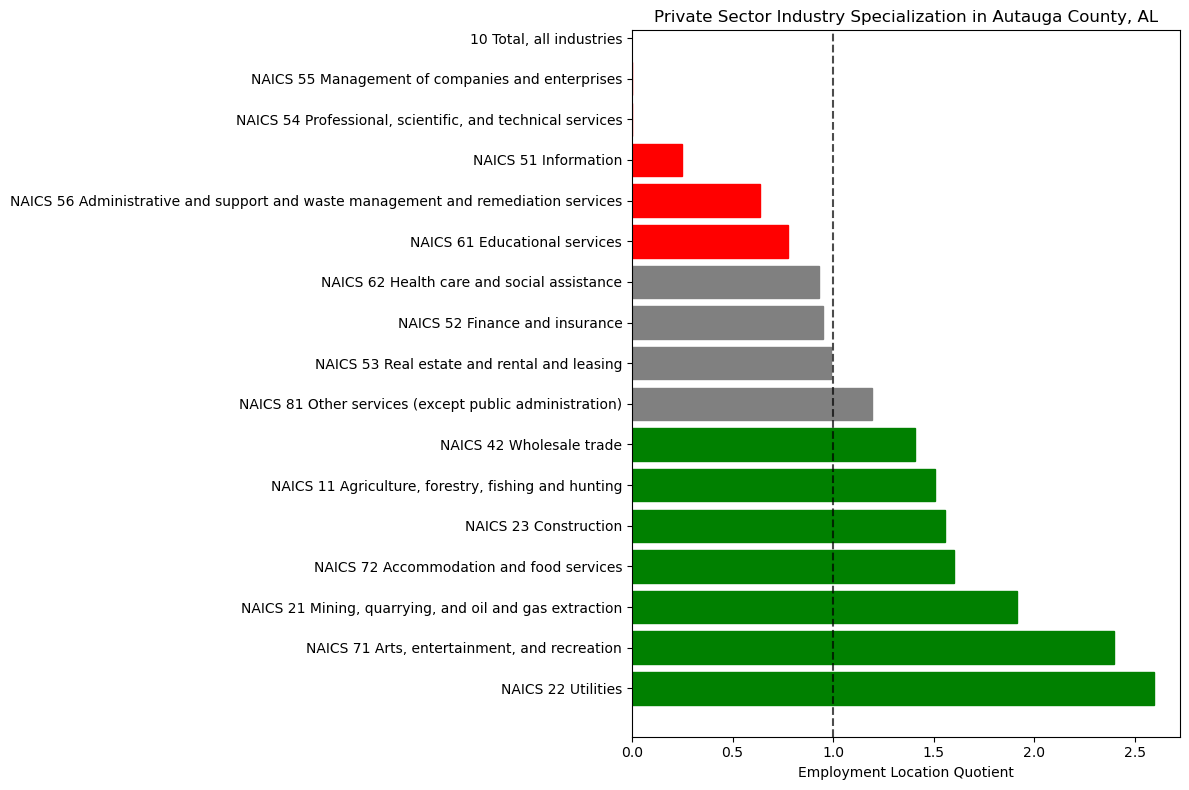


QCEW Analysis Complete!


In [ ]:
# Create a visualization of location quotients for a sample county
if len(lq_data) > 0:
    sample_county = lq_data['area_fips'].iloc[0]
    county_name = lq_data[lq_data['area_fips'] == sample_county]['area_title'].iloc[0]

    # Filter data for this county
    county_lq = lq_data[lq_data['area_fips'] == sample_county].copy()

    # Sort by LQ for better visualization
    county_lq = county_lq.sort_values('employment_lq', ascending=False)

    # Create plot
    plt.figure(figsize=(12, 8))
    bars = plt.barh(county_lq['industry_title'], county_lq['employment_lq'])

    # Color bars by representation
    for i, bar in enumerate(bars):
        if county_lq.iloc[i]['employment_representation'] == 'Over-represented':
            bar.set_color('green')
        elif county_lq.iloc[i]['employment_representation'] == 'Under-represented':
            bar.set_color('red')
        else:
            bar.set_color('gray')

    # Add a line at LQ = 1
    plt.axvline(x=1, color='black', linestyle='--', alpha=0.7)

    # Add labels and title
    plt.xlabel('Employment Location Quotient')
    plt.title(f'Private Sector Industry Specialization in {county_name}')
    plt.tight_layout()

    # Display plot
    plt.show()

print("\nQCEW Analysis Complete!")

# ACS Analysis

"""
ACS 1-Year Data Location Quotient Analysis with NAICS 2-Digit Mapping

This script analyzes American Community Survey (ACS) 1-year data to identify 
industries and occupations that are over and under-represented in counties with 
populations around 65,000 using location quotients. Industry data is mapped to 
NAICS 2-digit sector codes to provide standardized categorization.

Requirements:
- census package (pip install census)
- pandas (pip install pandas)
- us (pip install us)
- matplotlib (pip install matplotlib)
- seaborn (pip install seaborn)

"""

# ACS Analysis

"""
ACS 1-Year Data Location Quotient Analysis with NAICS 2-Digit Mapping

This script analyzes American Community Survey (ACS) 1-year data to identify 
industries and occupations that are over and under-represented in counties with 
populations around 65,000 using location quotients. Industry data is mapped to 
NAICS 2-digit sector codes to provide standardized categorization.

Requirements:
- census package (pip install census)
- pandas (pip install pandas)
- us (pip install us)
- matplotlib (pip install matplotlib)
- seaborn (pip install seaborn)

"""

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from census import Census
from us import states

In [ ]:
# Import API key from config.py file
from config import credentials
API_KEY = credentials['CENSUS_API_KEY']

# Initialize Census API connection
c = Census(API_KEY)

# Note: ACS 1-year data is only available for geographies with populations of 65,000+

In [ ]:
# Define mapping from ACS industry categories to NAICS 2-digit codes
# This mapping is based on standard NAICS 2-digit sector codes and their relationship
# to ACS industry categories in table C24030
NAICS_MAPPING = {
    # ACS Category: (NAICS 2-digit code, NAICS sector name)
    'Agriculture_Mining': {
        'naics_codes': ['11', '21'],
        'naics_names': ['Agriculture, Forestry, Fishing and Hunting', 'Mining, Quarrying, and Oil and Gas Extraction']
    },
    'Construction': {
        'naics_codes': ['23'],
        'naics_names': ['Construction']
    },
    'Manufacturing': {
        'naics_codes': ['31', '32', '33'],
        'naics_names': ['Manufacturing']
    },
    'Wholesale_Trade': {
        'naics_codes': ['42'],
        'naics_names': ['Wholesale Trade']
    },
    'Retail_Trade': {
        'naics_codes': ['44', '45'],
        'naics_names': ['Retail Trade']
    },
    'Transportation_Utilities': {
        'naics_codes': ['48', '49', '22'],
        'naics_names': ['Transportation and Warehousing', 'Utilities']
    },
    'Information': {
        'naics_codes': ['51'],
        'naics_names': ['Information']
    },
    'Finance_RealEstate': {
        'naics_codes': ['52', '53'],
        'naics_names': ['Finance and Insurance', 'Real Estate and Rental and Leasing']
    },
    'Professional_Scientific_Management': {
        'naics_codes': ['54', '55', '56'],
        'naics_names': ['Professional, Scientific, and Technical Services', 
                        'Management of Companies and Enterprises',
                        'Administrative and Support and Waste Management and Remediation Services']
    },
    'Education_HealthCare': {
        'naics_codes': ['61', '62'],
        'naics_names': ['Educational Services', 'Health Care and Social Assistance']
    },
    'Arts_Entertainment_Food': {
        'naics_codes': ['71', '72'],
        'naics_names': ['Arts, Entertainment, and Recreation', 
                        'Accommodation and Food Services']
    },
    'Other_Services': {
        'naics_codes': ['81'],
        'naics_names': ['Other Services (except Public Administration)']
    },
    'Public_Administration': {
        'naics_codes': ['92'],
        'naics_names': ['Public Administration']
    }
}

In [ ]:
# Function to get all counties with ACS 1-year data
def get_counties(year=2023):
    """
    Get all counties from the ACS 1-year data.
    ACS 1-year only includes geographies with populations of 65,000+
    """
    print("Fetching counties with ACS 1-year data...")
    
    # Get data for all counties (B01003_001E is total population)
    county_data = c.acs1.get(
        ('NAME', 'B01003_001E'),
        {'for': 'county:*', 'in': 'state:*'},
        year=year
    )
    
    # Convert to DataFrame
    counties_df = pd.DataFrame(county_data)
    counties_df.columns = ['NAME', 'POPULATION', 'state', 'county']
    counties_df['POPULATION'] = counties_df['POPULATION'].astype(int)
    
    # Create FIPS code for easier joining later
    counties_df['FIPS'] = counties_df['state'] + counties_df['county']
    
    return counties_df

# Get counties and show basic stats
counties_df = get_counties()
print(f"Found {len(counties_df)} counties with ACS 1-year data")
counties_df.head()

In [ ]:
# Function to get industry data
def get_industry_data(counties_df, year=2023):
    """
    Get industry employment data for specified counties
    Using ACS table C24030 - Sex by Industry for Civilian Population 16+ Years
    """
    print("Fetching industry data...")
    
    # Identify all counties to query
    fips_list = list(counties_df['FIPS'].unique())
    
    # Create a list to store data from multiple API calls
    all_industry_data = []
    
    # Process counties in batches to avoid API limitations
    batch_size = 50
    for i in range(0, len(fips_list), batch_size):
        batch_fips = fips_list[i:i+batch_size]
        
        # Create a list of dictionaries for 'in' clause 
        # (each county needs its own state/county pair)
        in_clauses = []
        for fips in batch_fips:
            state_fips = fips[:2]
            county_fips = fips[2:]
            in_clauses.append({
                'for': f'county:{county_fips}',
                'in': f'state:{state_fips}'
            })
        
        # For civilian employed population 16 years and over
        # C24030_001E: Total Civilian Employed
        # Get all industry codes from C24030 table (approximately 50 variables)
        industry_vars = [
            'C24030_001E',  # Total
            # Agriculture, forestry, fishing and hunting, and mining
            'C24030_003E', 'C24030_030E',  # Male + Female
            # Construction
            'C24030_004E', 'C24030_031E',  # Male + Female
            # Manufacturing
            'C24030_005E', 'C24030_032E',  # Male + Female
            # Wholesale trade
            'C24030_006E', 'C24030_033E',  # Male + Female
            # Retail trade
            'C24030_007E', 'C24030_034E',  # Male + Female
            # Transportation and warehousing, and utilities
            'C24030_008E', 'C24030_035E',  # Male + Female
            # Information
            'C24030_009E', 'C24030_036E',  # Male + Female
            # Finance and insurance, and real estate, and rental and leasing
            'C24030_010E', 'C24030_037E',  # Male + Female
            # Professional, scientific, management, administrative, and waste management
            'C24030_011E', 'C24030_038E',  # Male + Female
            # Educational services, and health care and social assistance
            'C24030_012E', 'C24030_039E',  # Male + Female
            # Arts, entertainment, recreation, accommodation and food services
            'C24030_013E', 'C24030_040E',  # Male + Female
            # Other services, except public administration
            'C24030_014E', 'C24030_041E',  # Male + Female
            # Public administration
            'C24030_015E', 'C24030_042E',  # Male + Female
        ]
        
        for in_clause in in_clauses:
            batch_data = c.acs1.get(['NAME'] + industry_vars, in_clause, year=year)
            all_industry_data.extend(batch_data)
    
    # Convert to DataFrame
    industry_df = pd.DataFrame(all_industry_data)
    
    # Rename columns for clarity
    column_names = {
        'C24030_001E': 'Total_Employed',
        'NAME': 'NAME',
        'state': 'state',
        'county': 'county'
    }
    
    # Define industry categories and their corresponding male/female codes
    industry_categories = {
        'Agriculture_Mining': ['C24030_003E', 'C24030_030E'],
        'Construction': ['C24030_004E', 'C24030_031E'],
        'Manufacturing': ['C24030_005E', 'C24030_032E'],
        'Wholesale_Trade': ['C24030_006E', 'C24030_033E'],
        'Retail_Trade': ['C24030_007E', 'C24030_034E'],
        'Transportation_Utilities': ['C24030_008E', 'C24030_035E'],
        'Information': ['C24030_009E', 'C24030_036E'],
        'Finance_RealEstate': ['C24030_010E', 'C24030_037E'],
        'Professional_Scientific_Management': ['C24030_011E', 'C24030_038E'],
        'Education_HealthCare': ['C24030_012E', 'C24030_039E'],
        'Arts_Entertainment_Food': ['C24030_013E', 'C24030_040E'],
        'Other_Services': ['C24030_014E', 'C24030_041E'],
        'Public_Administration': ['C24030_015E', 'C24030_042E']
    }
    
    # Add industry categories to column names
    for category, codes in industry_categories.items():
        column_names[codes[0]] = f'Male_{category}'
        column_names[codes[1]] = f'Female_{category}'
    
    # Rename columns
    industry_df = industry_df.rename(columns=column_names)
    
    # Convert numeric columns to integers
    for col in industry_df.columns:
        if col not in ['NAME', 'state', 'county']:
            industry_df[col] = pd.to_numeric(industry_df[col], errors='coerce')
    
    # Calculate total for each industry category
    for category in industry_categories.keys():
        industry_df[category] = industry_df[f'Male_{category}'] + industry_df[f'Female_{category}']
    
    # Create FIPS code
    industry_df['FIPS'] = industry_df['state'] + industry_df['county']
    
    # Add NAICS code information
    for category in industry_categories.keys():
        if category in NAICS_MAPPING:
            naics_info = NAICS_MAPPING[category]
            industry_df[f'{category}_NAICS'] = ','.join(naics_info['naics_codes'])
            industry_df[f'{category}_NAICS_NAME'] = '; '.join(naics_info['naics_names'])
    
    return industry_df

# Get industry data
county_industry_df = get_industry_data(counties_df)
county_industry_df.head()

In [ ]:
# Function to get occupation data
def get_occupation_data(counties_df, year=2023):
    """
    Get occupation employment data for specified counties
    Using ACS table C24010 - Sex by Occupation for Civilian Population 16+ Years
    """
    print("Fetching occupation data...")
    
    # Identify all counties to query
    fips_list = list(counties_df['FIPS'].unique())
    
    # Create a list to store data from multiple API calls
    all_occupation_data = []
    
    # Process counties in batches to avoid API limitations
    batch_size = 50
    for i in range(0, len(fips_list), batch_size):
        batch_fips = fips_list[i:i+batch_size]
        
        # Create a list of dictionaries for 'in' clause
        in_clauses = []
        for fips in batch_fips:
            state_fips = fips[:2]
            county_fips = fips[2:]
            in_clauses.append({
                'for': f'county:{county_fips}',
                'in': f'state:{state_fips}'
            })
        
        # Major occupation groups from C24010
        occupation_vars = [
            'C24010_001E',  # Total
            # Management, business, science, and arts occupations
            'C24010_003E', 'C24010_039E',  # Male + Female
            # Service occupations
            'C24010_004E', 'C24010_040E',  # Male + Female
            # Sales and office occupations
            'C24010_005E', 'C24010_041E',  # Male + Female
            # Natural resources, construction, and maintenance occupations
            'C24010_006E', 'C24010_042E',  # Male + Female
            # Production, transportation, and material moving occupations
            'C24010_007E', 'C24010_043E',  # Male + Female
        ]
        
        for in_clause in in_clauses:
            batch_data = c.acs1.get(['NAME'] + occupation_vars, in_clause, year=year)
            all_occupation_data.extend(batch_data)
    
    # Convert to DataFrame
    occupation_df = pd.DataFrame(all_occupation_data)
    
    # Rename columns for clarity
    column_names = {
        'C24010_001E': 'Total_Employed',
        'NAME': 'NAME',
        'state': 'state',
        'county': 'county'
    }
    
    # Define occupation categories and their corresponding male/female codes
    occupation_categories = {
        'Management_Business_Science_Arts': ['C24010_003E', 'C24010_039E'],
        'Service': ['C24010_004E', 'C24010_040E'],
        'Sales_Office': ['C24010_005E', 'C24010_041E'],
        'Natural_Resources_Construction': ['C24010_006E', 'C24010_042E'],
        'Production_Transportation': ['C24010_007E', 'C24010_043E']
    }
    
    # Add occupation categories to column names
    for category, codes in occupation_categories.items():
        column_names[codes[0]] = f'Male_{category}'
        column_names[codes[1]] = f'Female_{category}'
    
    # Rename columns
    occupation_df = occupation_df.rename(columns=column_names)
    
    # Convert numeric columns to integers
    for col in occupation_df.columns:
        if col not in ['NAME', 'state', 'county']:
            occupation_df[col] = pd.to_numeric(occupation_df[col], errors='coerce')
    
    # Calculate total for each occupation category
    for category in occupation_categories.keys():
        occupation_df[category] = occupation_df[f'Male_{category}'] + occupation_df[f'Female_{category}']
    
    # Create FIPS code
    occupation_df['FIPS'] = occupation_df['state'] + occupation_df['county']
    
    return occupation_df

# Get occupation data
county_occupation_df = get_occupation_data(counties_df)
county_occupation_df.head()

In [ ]:
# Function to calculate location quotients for industries
def calculate_industry_lq(industry_df):
    """Calculate location quotients for each industry category"""
    print("Calculating industry location quotients...")
    
    industry_categories = [
        'Agriculture_Mining', 'Construction', 'Manufacturing', 'Wholesale_Trade',
        'Retail_Trade', 'Transportation_Utilities', 'Information', 'Finance_RealEstate',
        'Professional_Scientific_Management', 'Education_HealthCare', 
        'Arts_Entertainment_Food', 'Other_Services', 'Public_Administration'
    ]
    
    # Calculate national shares
    national_totals = industry_df.sum()
    national_shares = {}
    
    for category in industry_categories:
        national_shares[category] = national_totals[category] / national_totals['Total_Employed']
    
    # Calculate location quotients for each county
    for category in industry_categories:
        # Local share
        industry_df[f'{category}_Share'] = industry_df[category] / industry_df['Total_Employed']
        
        # Location quotient
        industry_df[f'{category}_LQ'] = industry_df[f'{category}_Share'] / national_shares[category]
    
    return industry_df

# Function to calculate location quotients for occupations
def calculate_occupation_lq(occupation_df):
    """Calculate location quotients for each occupation category"""
    print("Calculating occupation location quotients...")
    
    occupation_categories = [
        'Management_Business_Science_Arts', 'Service', 'Sales_Office',
        'Natural_Resources_Construction', 'Production_Transportation'
    ]
    
    # Calculate national shares
    national_totals = occupation_df.sum()
    national_shares = {}
    
    for category in occupation_categories:
        national_shares[category] = national_totals[category] / national_totals['Total_Employed']
    
    # Calculate location quotients for each county
    for category in occupation_categories:
        # Local share
        occupation_df[f'{category}_Share'] = occupation_df[category] / occupation_df['Total_Employed']
        
        # Location quotient
        occupation_df[f'{category}_LQ'] = occupation_df[f'{category}_Share'] / national_shares[category]
    
    return occupation_df

# Calculate location quotients
county_industry_lq = calculate_industry_lq(county_industry_df)
county_occupation_lq = calculate_occupation_lq(county_occupation_df)

# Show sample of location quotient results
county_industry_lq[['NAME', 'FIPS', 'Total_Employed'] + 
                   [f'{cat}_LQ' for cat in ['Agriculture_Mining', 'Manufacturing', 'Professional_Scientific_Management']]].head()

In [ ]:
# Function to identify over and under-represented industries by NAICS 2-digit code
def identify_over_under_represented_naics2(industry_df):
    """
    Identify over and under-represented industries by NAICS 2-digit code
    LQ > 1.2: Over-represented
    LQ < 0.8: Under-represented
    """
    print("Identifying over and under-represented industries by NAICS 2-digit code...")
    
    # Get ACS industry categories
    acs_industry_categories = [
        'Agriculture_Mining', 'Construction', 'Manufacturing', 'Wholesale_Trade',
        'Retail_Trade', 'Transportation_Utilities', 'Information', 'Finance_RealEstate',
        'Professional_Scientific_Management', 'Education_HealthCare', 
        'Arts_Entertainment_Food', 'Other_Services', 'Public_Administration'
    ]
    
    # Create DataFrame to store results
    results = []
    
    for _, row in industry_df.iterrows():
        county_name = row['NAME']
        county_fips = row['FIPS']
        
        over_represented_naics = []
        under_represented_naics = []
        
        for category in acs_industry_categories:
            lq = row[f'{category}_LQ']
            naics_codes = NAICS_MAPPING[category]['naics_codes']
            naics_names = NAICS_MAPPING[category]['naics_names']
            
            # For each NAICS 2-digit code in this category
            for i, naics_code in enumerate(naics_codes):
                naics_name = naics_names[min(i, len(naics_names)-1)]
                
                if lq > 1.2:
                    over_represented_naics.append((naics_code, naics_name, lq))
                elif lq < 0.8:
                    under_represented_naics.append((naics_code, naics_name, lq))
        
        # Sort by NAICS code
        over_represented_naics.sort(key=lambda x: x[0])
        under_represented_naics.sort(key=lambda x: x[0])
        
        # Add to results
        results.append({
            'FIPS': county_fips,
            'County': county_name,
            'Over-represented_NAICS': over_represented_naics,
            'Under-represented_NAICS': under_represented_naics
        })
    
    return pd.DataFrame(results)

# Identify over and under-represented industries by NAICS 2-digit code
naics2_results = identify_over_under_represented_naics2(county_industry_lq)
naics2_results.head()

In [ ]:
# Function to visualize location quotients by NAICS 2-digit code
def visualize_lq_naics2(industry_df, county_fips):
    """Create a bar chart of location quotients by NAICS 2-digit sector for a specific county"""
    
    # Filter for the specific county
    county_data = industry_df[industry_df['FIPS'] == county_fips].iloc[0]
    county_name = county_data['NAME']
    
    # Get all NAICS 2-digit codes and their location quotients
    naics_lq_data = []
    
    for category in NAICS_MAPPING.keys():
        lq = county_data[f'{category}_LQ']
        naics_codes = NAICS_MAPPING[category]['naics_codes']
        naics_names = NAICS_MAPPING[category]['naics_names']
        
        for i, naics_code in enumerate(naics_codes):
            naics_name = naics_names[min(i, len(naics_names)-1)]
            naics_lq_data.append((naics_code, naics_name, lq))
    
    # Sort by NAICS code
    naics_lq_data.sort(key=lambda x: x[0])
    
    # Extract data for plotting
    naics_codes = [f"{code} - {name[:15]}..." for code, name, _ in naics_lq_data]
    lq_values = [lq for _, _, lq in naics_lq_data]
    
    # Create bar chart
    plt.figure(figsize=(15, 8))
    bars = plt.bar(naics_codes, lq_values)
    
    # Add reference line at LQ = 1
    plt.axhline(y=1, color='r', linestyle='-', alpha=0.3)
    
    # Color the bars based on over/under-representation
    for i, bar in enumerate(bars):
        if lq_values[i] > 1.2:
            bar.set_color('green')
        elif lq_values[i] < 0.8:
            bar.set_color('red')
        else:
            bar.set_color('blue')
    
    # Add labels and title
    plt.xlabel('NAICS 2-Digit Sectors')
    plt.ylabel('Location Quotient')
    plt.title(f'NAICS 2-Digit Sector Location Quotients for {county_name}')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Add LQ values as text labels
    for i, v in enumerate(lq_values):
        plt.text(i, v + 0.05, f'{v:.2f}', ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Optionally save figure
    # plt.savefig(f'{county_fips}_naics2_lq.png')
    # plt.close()

# Select a county to visualize (you may want to choose one that's interesting to you)
# For example, use the first county in the dataset
example_county_fips = county_industry_lq['FIPS'].iloc[0]
visualize_lq_naics2(county_industry_lq, example_county_fips)

In [ ]:
# Function to generate summary report with NAICS 2-digit information
def generate_naics2_report(county_results, industry_df, num_counties=5):
    """Generate a summary report of over and under-represented industries by NAICS 2-digit code"""
    print("Generating NAICS 2-digit summary report...")
    
    # Limit to specified number of counties for brevity in notebook
    results_subset = county_results.head(num_counties)
    
    for _, row in results_subset.iterrows():
        county_fips = row['FIPS']
        county_name = row['County']
        county_population = industry_df[industry_df['FIPS'] == county_fips]['Total_Employed'].values[0]
        
        print(f"\nCounty: {county_name}")
        print(f"Employed Population: {county_population}")
        print("\nNAICS 2-DIGIT SECTORS:")
        
        # Over-represented NAICS sectors
        print("  Over-represented (LQ > 1.2):")
        if row['Over-represented_NAICS']:
            for naics_code, naics_name, lq in row['Over-represented_NAICS']:
                print(f"    - NAICS {naics_code}: {naics_name} (LQ: {lq:.2f})")
        else:
            print("    None")
        
        # Under-represented NAICS sectors
        print("  Under-represented (LQ < 0.8):")
        if row['Under-represented_NAICS']:
            for naics_code, naics_name, lq in row['Under-represented_NAICS']:
                print(f"    - NAICS {naics_code}: {naics_name} (LQ: {lq:.2f})")
        else:
            print("    None")
        
        print("-" * 80)

# Generate report for a subset of counties
generate_naics2_report(naics2_results, county_industry_lq, num_counties=3)

In [ ]:
# Save data for further analysis
county_industry_lq.to_csv('county_industry_naics2_lq.csv', index=False)
county_occupation_lq.to_csv('county_occupation_lq.csv', index=False)
print("Analysis complete. Data saved to CSV files.")

In [ ]:
# Identify counties in the bottom 20% of employment
county_totals = county_industry_lq[['FIPS', 'NAME', 'Total_Employed']].copy()
threshold = county_totals['Total_Employed'].quantile(0.20)

small_counties = county_totals.loc[
    county_totals['Total_Employed'] <= threshold,
    'FIPS'
].tolist()

print(f"{len(small_counties)} small counties (≤ 20th pctile, ≤ {threshold:.0f} jobs)")

# Filter the industry LQ data to just those small counties
small_county_lq = county_industry_lq.loc[
    county_industry_lq['FIPS'].isin(small_counties)
].copy()

# Create a table to store results of over/under-represented industries
industry_categories = [
    'Agriculture_Mining', 'Construction', 'Manufacturing', 'Wholesale_Trade',
    'Retail_Trade', 'Transportation_Utilities', 'Information', 'Finance_RealEstate',
    'Professional_Scientific_Management', 'Education_HealthCare', 
    'Arts_Entertainment_Food', 'Other_Services', 'Public_Administration'
]

# Create a DataFrame to store the classification results
small_county_results = []

for _, row in small_county_lq.iterrows():
    county_fips = row['FIPS']
    county_name = row['NAME']
    
    # Check each industry category
    for category in industry_categories:
        lq = row[f'{category}_LQ']
        naics_codes = NAICS_MAPPING[category]['naics_codes']
        naics_names = '; '.join(NAICS_MAPPING[category]['naics_names'])
        
        # Classify as over or under-represented
        if lq > 1.2:
            representation = "Over-represented"
        elif lq < 0.8:
            representation = "Under-represented"
        else:
            representation = "Neutral"  # Skip if neither over nor under-represented
            continue
        
        # Add to results
        small_county_results.append({
            'FIPS': county_fips,
            'County': county_name,
            'Total_Employed': row['Total_Employed'],
            'Industry_Category': category,
            'NAICS_Codes': ','.join(naics_codes),
            'NAICS_Names': naics_names,
            'LQ': lq,
            'Representation': representation
        })

# Convert to DataFrame
small_county_representation_df = pd.DataFrame(small_county_results)

# Group the results by county and representation
grouped_results = (
    small_county_representation_df
    .groupby(['FIPS', 'County', 'Representation'])['Industry_Category']
    .apply(list)
    .reset_index()
)

# Print examples of counties and their over/under-represented industries
print("\nExample counties with their over/under-represented industries:")
print("-" * 80)

for _, row in grouped_results.head(10).iterrows():
    print(
        f"{row.FIPS} ({row.County}) — "
        f"{row.Representation}: "
        f"{', '.join(row.Industry_Category)}"
    )

# Additional analysis: Find the most common over/under-represented industries in small counties
print("\nMost common over-represented industries in small counties:")
print("-" * 80)
over_represented_counts = small_county_representation_df[
    small_county_representation_df['Representation'] == 'Over-represented'
]['Industry_Category'].value_counts()
print(over_represented_counts.head(5))

print("\nMost common under-represented industries in small counties:")
print("-" * 80)
under_represented_counts = small_county_representation_df[
    small_county_representation_df['Representation'] == 'Under-represented'
]['Industry_Category'].value_counts()
print(under_represented_counts.head(5))

# Visualize the distribution of over/under-represented industries in small counties
plt.figure(figsize=(12, 8))
ax = sns.countplot(
    data=small_county_representation_df,
    x='Industry_Category',
    hue='Representation',
    palette={'Over-represented': 'green', 'Under-represented': 'red'}
)
plt.title('Distribution of Over/Under-Represented Industries in Small Counties')
plt.xlabel('Industry Category')
plt.ylabel('Count of Counties')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()